# SN10 classifier and integrated gradients attribution

In this notebook, we develop the SN10 classifier used in `Absolut!` and the integrated-gradients method of attribution. We might also check other attribution methods.

In [1]:
import os
from pathlib import Path
from typing import List

import pandas as pd
import numpy as np
import seaborn as sns
import joypy

import torch
from torch import nn
from torch.utils.data import DataLoader
from captum.attr import IntegratedGradients, DeepLift

import NegativeClassOptimization.config as config
import NegativeClassOptimization.utils as utils
import NegativeClassOptimization.preprocessing as preprocessing
from NegativeClassOptimization import ml
from NegativeClassOptimization import datasets

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Let's load the data on which we are going to develop the binary classifier.

In [2]:
df = utils.load_global_dataframe()

ag_pos = "3VRL"
ag_neg = "1ADQ"
df = df.loc[df["Antigen"].isin([ag_pos, ag_neg])].copy()
df = df.drop_duplicates(["Slide"])

N = 1000
df = df.sample(n=N, random_state=42)
df = df.sample(frac=1, random_state=42)

df_train = df.iloc[:int(N*0.8)]
df_test = df.iloc[int(N*0.8):]

First, handle duplicates.

In [3]:
train_data, test_data, train_loader, test_loader = preprocessing.preprocess_data_for_pytorch_binary(
    df_train_val=df_train,
    df_test_closed=df_test,
    ag_pos=[ag_pos],
    batch_size=32,
    scale_X=False,
)

/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:261: UserWarning: Not scaling X.
  warnings.warn("Not scaling X.")


Setup the model.

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = ml.SN10().to(device)
print(model)

Using cpu device
SN10(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=220, out_features=10, bias=True)
  (activation): ReLU()
  (linear_2): Linear(in_features=10, out_features=1, bias=True)
  (final): Sigmoid()
)


Setup and run optimization.

In [5]:
model = ml.SN10()
model = model.to("cpu")

learning_rate = 0.01
epochs = 3
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    ml.train_loop(train_loader, model, loss_fn, optimizer)
    ml.test_loop(test_loader, model, loss_fn)

Epoch 1
-------------------------------
loss: 0.676813  [    0/  800]


/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Acc: 54.0 Avg loss: 0.685590 

Epoch 2
-------------------------------
loss: 0.685368  [    0/  800]


/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Acc: 54.0 Avg loss: 0.681514 

Epoch 3
-------------------------------
loss: 0.695975  [    0/  800]
Test Error: 
 Acc: 54.5 Avg loss: 0.684485 



Having trained a model, we explore integrated gradients as an attribution method. As baseline, we use the zero one-hot tensor. 

Computing integrated gradients for feature $i$:

$$\text{IntegratedGrads}_i^{approx}(x) = (x_i-x_i') \cdot \frac{1}{m} \cdot \sum_{k=1}^{m}\frac{\partial F(x'+\frac{k}{m}\cdot (x-x'))}{\partial x_i}$$

Essential for the implementation is computing:

$$\frac{\partial F(x'+\frac{k}{m}\cdot (x-x'))}{\partial x_i}, \text{ where }F(x)\text{ is the SN10}$$

One issue concerns the baseline. I'm not sure a zero-valued one-hot vector is the relevant baseline. I should maybe try different baselines (such as different aminoacids, or some specific sequence). Also, Euclidian interpolation might not be relevant as well.

In any case, [Captum](https://captum.ai/) provides implementations for many interpretability methods. It looks like it also has interpretability methods for NLP models. It also has [a useful section](https://captum.ai/docs/algorithms_comparison_matrix) that compares algorithms.

For first, let's go with integrated gradients and compute for all the test set. It would also be useful to add visualisation like [Captum Insights](https://captum.ai/tutorials/CIFAR_TorchVision_Captum_Insights).

In [6]:
attributor = ml.Attributor(model, type="deep_lift", baseline_type="shuffle")

inp = test_data[0][0].reshape((-1, 11*20))
attributor(inp)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


tensor([[-4.7592e-03,  0.0000e+00, -0.0000e+00,  0.0000e+00,  1.3784e-03,
          5.7538e-04, -0.0000e+00, -0.0000e+00, -0.0000e+00, -1.1212e-03,
         -0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00,  2.9705e-04,  1.1636e-03,
         -1.1226e-03,  0.0000e+00, -0.0000e+00, -0.0000e+00, -7.9632e-04,
          2.8517e-04, -0.0000e+00,  0.0000e+00,  0.0000e+00,  1.3593e-03,
         -0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0496e-04, -3.3325e-04,
         -5.2120e-04,  0.0000e+00, -0.0000e+00,  0.0000e+00, -6.4946e-04,
          1.6759e-03, -0.0000e+00,  0.0000e+00, -0.0000e+00,  6.6158e-04,
         -0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00,  4.2215e-04,  7.8486e-05,
          4.3787e-04, -0.0000e+00, -0.0000e+00,  0.0000e+00, -3.7724e-04,
         -1.7663e-05, -0.0000e+00,  0.

Short stability analysis.
- Plots are okay.
- For larger magnitudes (|.|>0.05) clearly okay, for smaller, likely okay.

In [7]:
attrs = []
baselines_pred = []
for _ in range(100):
    baseline = attributor.compute_baseline(inp)
    baselines_pred.append(model(baseline).detach().numpy().reshape((-1)))
    attribution, _ = attributor(inp, return_err=True)
    attrs.append(attribution.detach().numpy().reshape((1, -1)))

attrs = np.concatenate(attrs, axis=0)
print(f"{attrs.shape=}")

attrs.shape=(100, 220)


In [8]:
# Predicted values for the baselines
np.concatenate(baselines_pred, axis=0)

array([0.46807882, 0.46691564, 0.4677268 , 0.46695524, 0.46724403,
       0.46755874, 0.46713716, 0.4676174 , 0.4676014 , 0.46707213,
       0.4671399 , 0.4673368 , 0.46734285, 0.46740088, 0.46741983,
       0.46768346, 0.4666789 , 0.4670074 , 0.46684343, 0.46752852,
       0.467594  , 0.46815336, 0.46741307, 0.46752435, 0.4673514 ,
       0.46723342, 0.4668785 , 0.46729517, 0.46759233, 0.467035  ,
       0.46772715, 0.46748245, 0.46704197, 0.46719626, 0.4679341 ,
       0.46707284, 0.4668627 , 0.46688232, 0.46729448, 0.46741223,
       0.46773884, 0.46711037, 0.4668548 , 0.46726236, 0.46748036,
       0.46691364, 0.46713075, 0.46741447, 0.46800458, 0.4669809 ,
       0.46702126, 0.46740672, 0.4673367 , 0.4673338 , 0.46774697,
       0.46771428, 0.46692565, 0.4674872 , 0.46714443, 0.46824023,
       0.46735805, 0.46741378, 0.4672479 , 0.4675536 , 0.46753457,
       0.46663564, 0.4669982 , 0.46711686, 0.4679787 , 0.4677258 ,
       0.4676478 , 0.46737275, 0.46739972, 0.46700796, 0.46789

In [9]:
model(torch.zeros((1, 11*20)))

tensor([[0.4705]], grad_fn=<SigmoidBackward0>)

<AxesSubplot: xlabel='mean', ylabel='std'>

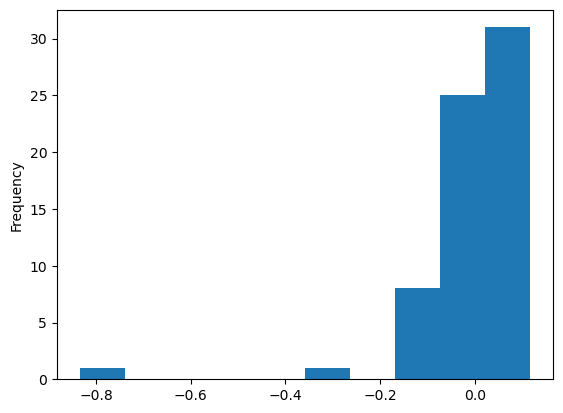

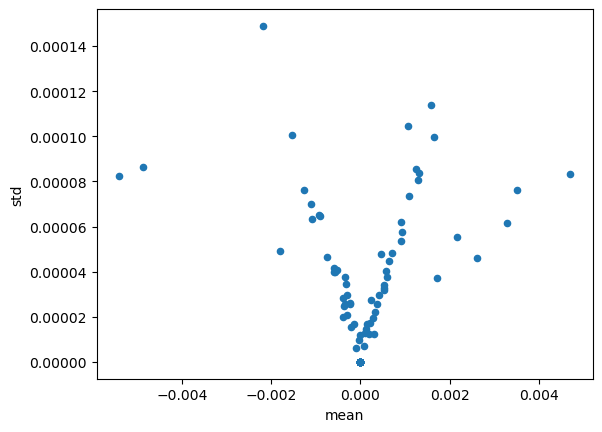

In [10]:
df_stab = pd.DataFrame(attrs).describe().loc[["mean", "std"]].transpose()
df_stab["cv"] = df_stab["std"] / df_stab["mean"]
df_stab["cv"].plot.hist()
df_stab.plot.scatter(x="mean", y="std")

Aggregating attributions and further analysis.

In [11]:
test_data_sample = datasets.BinaryDataset(test_data.df.sample(10).reset_index())
records = attributor.attribute_dataset(test_data_sample)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [13]:
def compute_attributions(test_data, attributor):
    records = attributor.attribute_dataset(test_data)

    attributions = list(map(lambda tupl: tupl[0].detach().numpy(), records))

    abs_sums = []
    for attr in attributions:
        abs_sum = np.abs(attr.reshape((11, 20))).sum(axis=1)
        abs_sums.append(abs_sum)

    slide_pos_cols = (f"Slide position {i}" for i in range(1, 12))
    df_attr = pd.DataFrame(data=np.stack(abs_sums), columns=slide_pos_cols)
    return attributions, df_attr

attributions, df_attr = compute_attributions(test_data, attributor)
attributions[0].shape

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


(1, 220)

In [14]:
df_ext = pd.DataFrame(
    data=np.stack(map(lambda a: a.reshape(-1), attributions)), 
    columns=(
        f"{position} {aa}" 
        for position in range (1, 12) 
        for aa in config.AMINOACID_ALPHABET
    )
)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [15]:
test_antigens = []
for i in DataLoader(test_data, batch_size=1):
    y_i = i[1].reshape(-1)
    if y_i == 0:
        test_antigens.append("1ADQ")
    elif y_i == 1:
        test_antigens.append("3VRL")
    else:
        raise RuntimeError()
df_attr["Antigen"] = test_antigens
df_attr.head(2)

,Slide position 1,Slide position 2,Slide position 3,Slide position 4,Slide position 5,Slide position 6,Slide position 7,Slide position 8,Slide position 9,Slide position 10,Slide position 11,Antigen
0,0.009671,0.004119,0.003865,0.004391,0.005575,0.007474,0.008713,0.002279,0.004947,0.007986,0.006555,1ADQ
1,0.010993,0.004440,0.006906,0.002425,0.007531,0.008381,0.005143,0.003736,0.004751,0.006865,0.004736,1ADQ


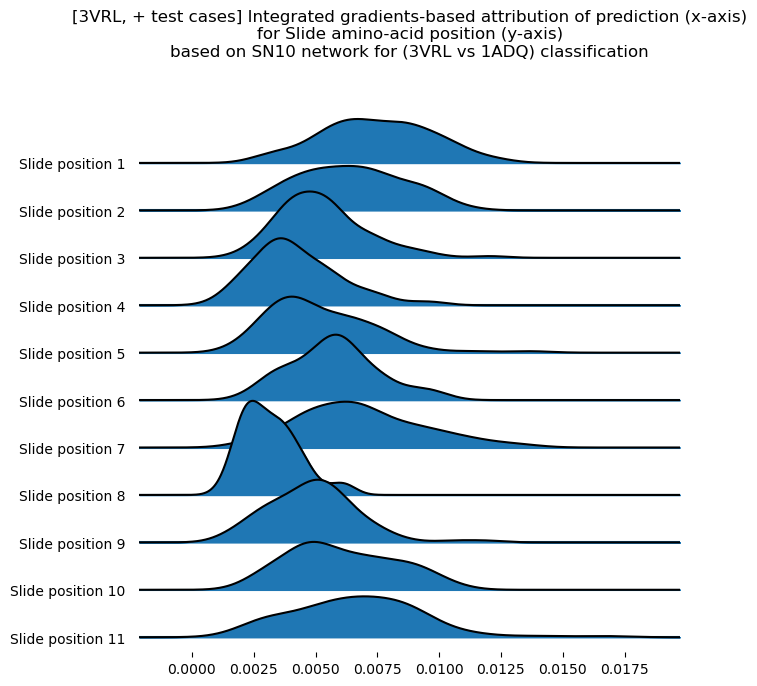

In [16]:
# joypy.joyplot(df_ext, figsize=(20, 15))
g = joypy.joyplot(
    df_attr.loc[df_attr["Antigen"] == "3VRL"].iloc[:, :-1],
    figsize=(7, 7),
    title="[3VRL, + test cases] Integrated gradients-based attribution of prediction (x-axis)\nfor Slide amino-acid position (y-axis)\nbased on SN10 network for (3VRL vs 1ADQ) classification")

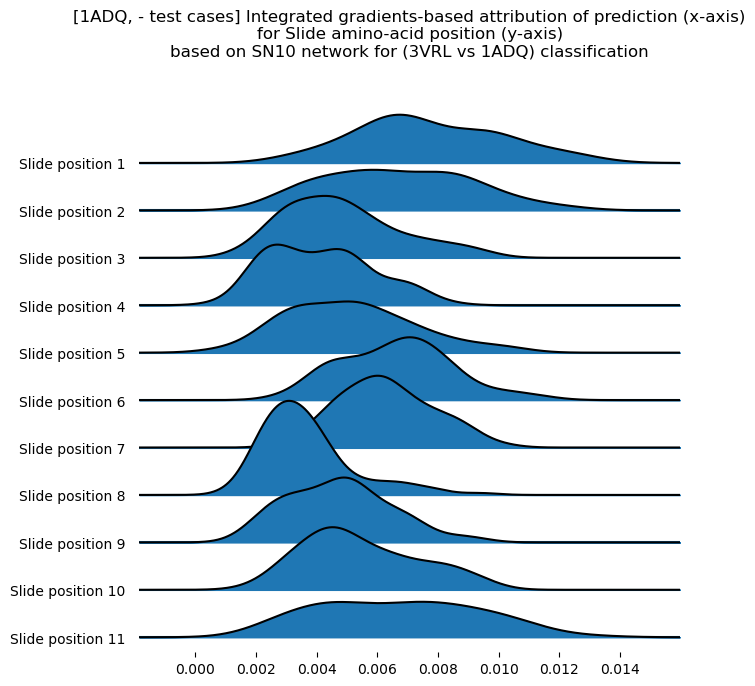

In [17]:
# joypy.joyplot(df_ext, figsize=(20, 15))
g = joypy.joyplot(
    df_attr.loc[df_attr["Antigen"] == "1ADQ"].iloc[:, :-1],
    figsize=(7, 7),
    title="[1ADQ, - test cases] Integrated gradients-based attribution of prediction (x-axis)\nfor Slide amino-acid position (y-axis)\nbased on SN10 network for (3VRL vs 1ADQ) classification")

## In-depth attribution analysis

In [18]:
df_ext

,1 A,1 C,1 D,1 E,1 F,1 G,1 H,1 I,1 K,1 L,...,11 M,11 N,11 P,11 Q,11 R,11 S,11 T,11 V,11 W,11 Y
0,-0.004883,0.0,-0.000000,0.000000,0.001706,0.000556,-0.0,-0.000000,-0.000000,-0.001155,...,-0.000000,-0.000000,0.0,0.0,-0.000000,-0.000000,-0.0,0.000000,-0.001745,-0.001441
1,-0.005479,0.0,0.000092,-0.000494,-0.000000,-0.000000,-0.0,0.000415,-0.000000,-0.001299,...,0.000962,-0.000000,0.0,0.0,0.000393,-0.000000,-0.0,0.000000,-0.000938,-0.000693
2,-0.004776,0.0,0.000141,0.000000,0.000840,-0.000000,-0.0,0.000471,0.000266,-0.001437,...,-0.000000,-0.000000,0.0,0.0,-0.000000,-0.000000,-0.0,0.000000,-0.001989,-0.002283
3,-0.003925,0.0,0.000236,0.000000,-0.000000,-0.000000,-0.0,0.000275,-0.000000,-0.001345,...,-0.007472,-0.000000,0.0,-0.0,0.000428,-0.000000,-0.0,0.000000,0.000000,-0.000816
4,-0.005860,0.0,0.000345,0.000000,0.000653,-0.000000,-0.0,0.000525,-0.000000,0.000000,...,-0.000000,0.000210,0.0,0.0,-0.000000,-0.000000,-0.0,-0.000601,-0.000280,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.000000,0.0,-0.000000,0.000000,0.000772,0.000215,-0.0,-0.000000,-0.000000,-0.001941,...,-0.000000,-0.000000,-0.0,0.0,0.000131,-0.000000,-0.0,0.000000,0.000282,-0.001529
196,-0.000000,0.0,0.000242,0.000000,0.001093,-0.000000,-0.0,-0.000000,-0.000000,-0.000615,...,-0.000000,0.000192,0.0,0.0,0.000207,0.000431,-0.0,0.000000,-0.000686,-0.001093
197,-0.000000,0.0,0.000160,0.000000,0.000636,0.000228,-0.0,-0.000000,-0.000000,0.000000,...,-0.000000,-0.000000,0.0,0.0,0.000098,-0.000000,-0.0,-0.000395,-0.001265,-0.001478
198,-0.000000,0.0,0.000267,0.000000,0.000607,-0.000000,-0.0,0.000531,-0.000000,-0.000657,...,-0.000000,-0.000000,0.0,0.0,-0.000000,-0.000000,-0.0,0.004285,0.000265,-0.002467


In [19]:
correct_preds = []
for i in range(len(test_data)):
    X_i = test_data[i][0]
    y_i = test_data[i][1]
    pred_correct = (model(X_i).round() == y_i).tolist()[0][0]
    correct_preds.append(pred_correct)
correct_preds = pd.Series(correct_preds)

mask_corr = correct_preds == True
mask_incorr = correct_preds == False

df_ext_correct = df_ext.loc[mask_corr].copy()
df_ext_incorrect = df_ext.loc[mask_incorr].copy()

In [20]:
y_true = []
for i in range(len(test_data)):
    y_true.append(test_data[i][1].tolist()[0])
y_true = pd.Series(y_true)

mask_agpos = y_true == 1
mask_agneg = y_true == 0

df_ext_1 = df_ext.loc[mask_agpos].copy()
df_ext_0 = df_ext.loc[mask_agneg].copy()

<AxesSubplot: title={'center': 'Mean vs Std of attributions: - - incorrect cases'}, xlabel='mean', ylabel='std'>

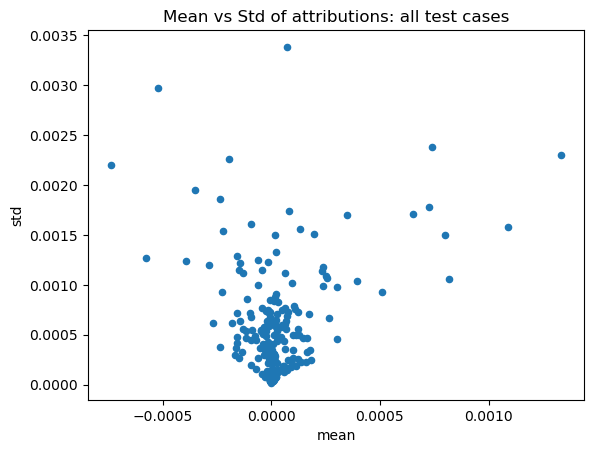

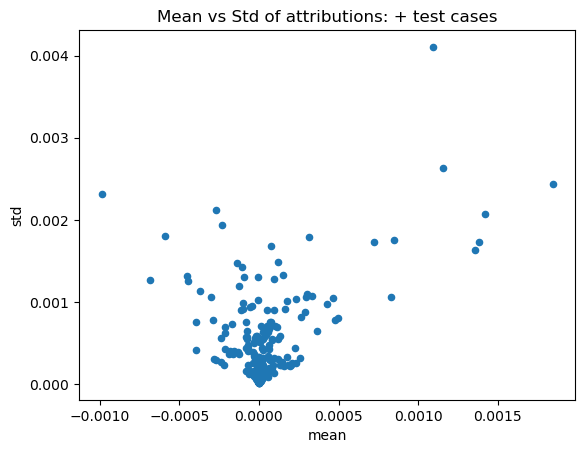

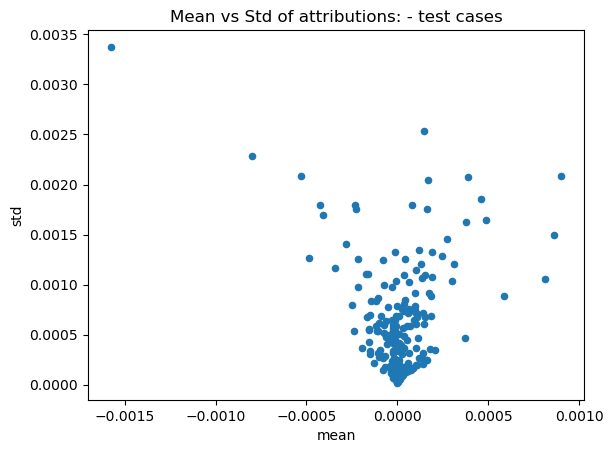

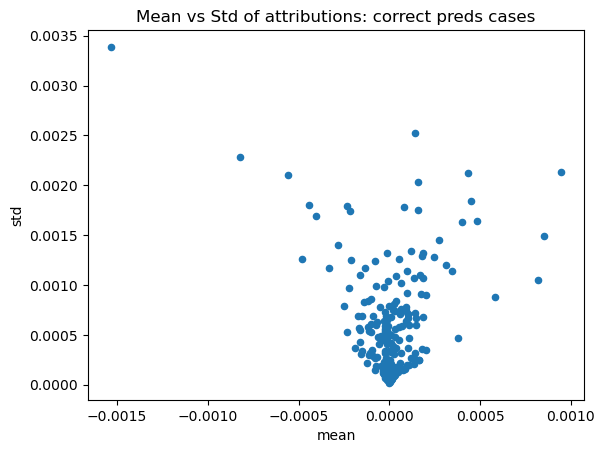

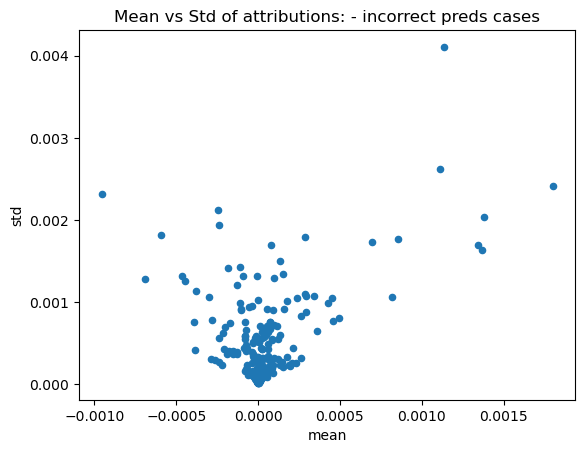

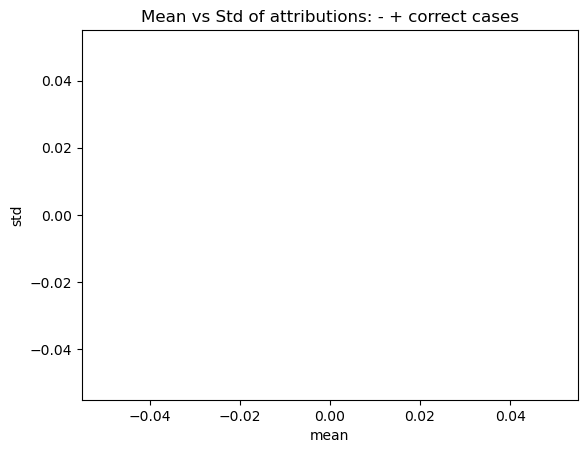

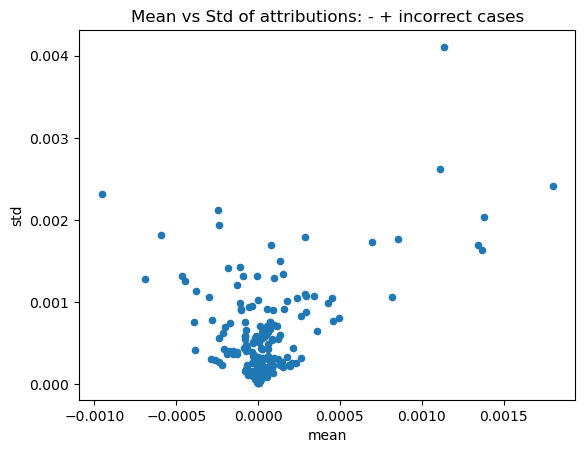

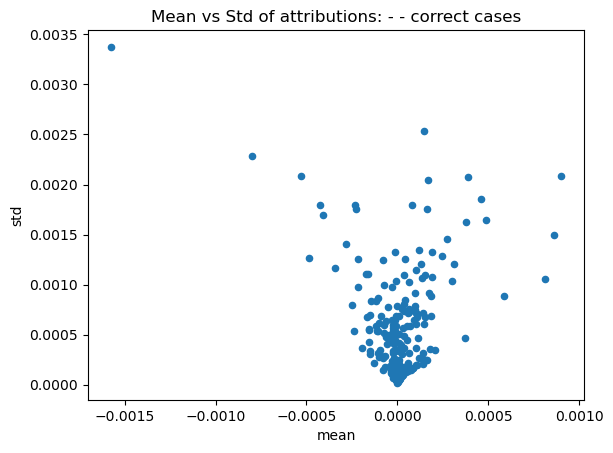

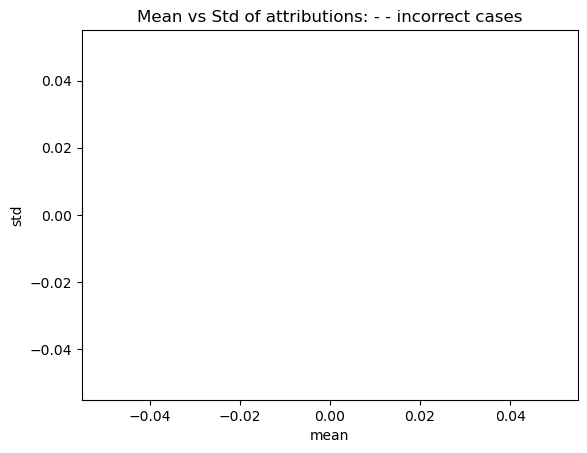

In [21]:
def get_col_descriptions(df: pd.DataFrame) -> pd.DataFrame:
    return df.describe().transpose()

get_col_descriptions(df_ext).plot.scatter(x="mean", y="std", title="Mean vs Std of attributions: all test cases")
get_col_descriptions(df_ext_1).plot.scatter(x="mean", y="std", title="Mean vs Std of attributions: + test cases")
get_col_descriptions(df_ext_0).plot.scatter(x="mean", y="std", title="Mean vs Std of attributions: - test cases")
get_col_descriptions(df_ext_correct).plot.scatter(x="mean", y="std", title="Mean vs Std of attributions: correct preds cases")
get_col_descriptions(df_ext_incorrect).plot.scatter(x="mean", y="std", title="Mean vs Std of attributions: - incorrect preds cases")

get_col_descriptions(df_ext.loc[mask_agpos & mask_corr]).plot.scatter(x="mean", y="std", title="Mean vs Std of attributions: - + correct cases")
get_col_descriptions(df_ext.loc[mask_agpos & mask_incorr]).plot.scatter(x="mean", y="std", title="Mean vs Std of attributions: - + incorrect cases")
get_col_descriptions(df_ext.loc[mask_agneg & mask_corr]).plot.scatter(x="mean", y="std", title="Mean vs Std of attributions: - - correct cases")
get_col_descriptions(df_ext.loc[mask_agneg & mask_incorr]).plot.scatter(x="mean", y="std", title="Mean vs Std of attributions: - - incorrect cases")

In [22]:
# get_col_descriptions(df_ext_1).sort_values("mean", ascending=False).head(30)
get_col_descriptions(df_ext_1).sort_values("50%", ascending=False).head(30)

,count,mean,std,min,25%,50%,75%,max
10 Y,92.0,0.001844,0.002434,-0.003394,-0.000312,0.001984,0.004009,0.006664
2 L,92.0,0.000721,0.001733,-0.006348,0.000353,0.001000,0.001480,0.004495
10 L,92.0,0.000830,0.001062,-0.003925,0.000543,0.000992,0.001325,0.003464
5 W,92.0,0.000847,0.001758,-0.010852,0.000688,0.000938,0.001557,0.003491
1 F,92.0,0.000313,0.001797,-0.007911,0.000441,0.000670,0.000915,0.002921
11 A,92.0,0.000495,0.000804,-0.005090,-0.000000,0.000600,0.000855,0.002705
1 Y,92.0,0.000425,0.000980,-0.005647,0.000253,0.000540,0.000798,0.002138
10 F,92.0,0.000476,0.000784,-0.005616,0.000359,0.000529,0.000695,0.002018
3 W,92.0,0.000336,0.001068,-0.005441,0.000337,0.000525,0.000709,0.001883
3 L,92.0,0.000464,0.001043,-0.003836,0.000190,0.000522,0.001109,0.002299


In [23]:
df_ext

,1 A,1 C,1 D,1 E,1 F,1 G,1 H,1 I,1 K,1 L,...,11 M,11 N,11 P,11 Q,11 R,11 S,11 T,11 V,11 W,11 Y
0,-0.004883,0.0,-0.000000,0.000000,0.001706,0.000556,-0.0,-0.000000,-0.000000,-0.001155,...,-0.000000,-0.000000,0.0,0.0,-0.000000,-0.000000,-0.0,0.000000,-0.001745,-0.001441
1,-0.005479,0.0,0.000092,-0.000494,-0.000000,-0.000000,-0.0,0.000415,-0.000000,-0.001299,...,0.000962,-0.000000,0.0,0.0,0.000393,-0.000000,-0.0,0.000000,-0.000938,-0.000693
2,-0.004776,0.0,0.000141,0.000000,0.000840,-0.000000,-0.0,0.000471,0.000266,-0.001437,...,-0.000000,-0.000000,0.0,0.0,-0.000000,-0.000000,-0.0,0.000000,-0.001989,-0.002283
3,-0.003925,0.0,0.000236,0.000000,-0.000000,-0.000000,-0.0,0.000275,-0.000000,-0.001345,...,-0.007472,-0.000000,0.0,-0.0,0.000428,-0.000000,-0.0,0.000000,0.000000,-0.000816
4,-0.005860,0.0,0.000345,0.000000,0.000653,-0.000000,-0.0,0.000525,-0.000000,0.000000,...,-0.000000,0.000210,0.0,0.0,-0.000000,-0.000000,-0.0,-0.000601,-0.000280,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.000000,0.0,-0.000000,0.000000,0.000772,0.000215,-0.0,-0.000000,-0.000000,-0.001941,...,-0.000000,-0.000000,-0.0,0.0,0.000131,-0.000000,-0.0,0.000000,0.000282,-0.001529
196,-0.000000,0.0,0.000242,0.000000,0.001093,-0.000000,-0.0,-0.000000,-0.000000,-0.000615,...,-0.000000,0.000192,0.0,0.0,0.000207,0.000431,-0.0,0.000000,-0.000686,-0.001093
197,-0.000000,0.0,0.000160,0.000000,0.000636,0.000228,-0.0,-0.000000,-0.000000,0.000000,...,-0.000000,-0.000000,0.0,0.0,0.000098,-0.000000,-0.0,-0.000395,-0.001265,-0.001478
198,-0.000000,0.0,0.000267,0.000000,0.000607,-0.000000,-0.0,0.000531,-0.000000,-0.000657,...,-0.000000,-0.000000,0.0,0.0,-0.000000,-0.000000,-0.0,0.004285,0.000265,-0.002467


In [24]:
df_ext_cor = df_ext.corr().dropna(axis=1, how="all").dropna(axis=0, how="all")

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


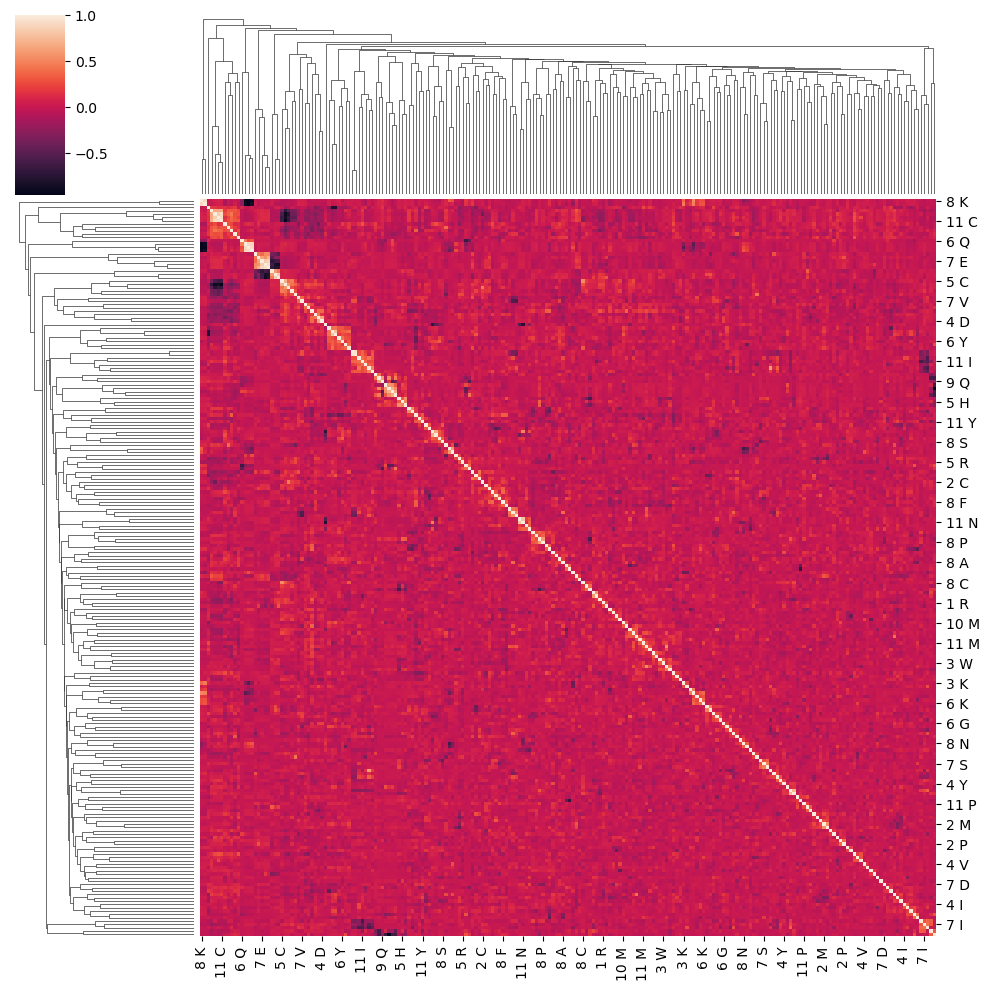

In [25]:
sns.clustermap(df_ext_cor, figsize=(10, 10))

### Looking at position-aggregated IG

In [26]:
df_attr

,Slide position 1,Slide position 2,Slide position 3,Slide position 4,Slide position 5,Slide position 6,Slide position 7,Slide position 8,Slide position 9,Slide position 10,Slide position 11,Antigen
0,0.009671,0.004119,0.003865,0.004391,0.005575,0.007474,0.008713,0.002279,0.004947,0.007986,0.006555,1ADQ
1,0.010993,0.004440,0.006906,0.002425,0.007531,0.008381,0.005143,0.003736,0.004751,0.006865,0.004736,1ADQ
2,0.009712,0.004586,0.007095,0.003952,0.004689,0.005228,0.006912,0.002898,0.006254,0.007405,0.006758,3VRL
3,0.008516,0.004813,0.002539,0.001602,0.007222,0.007973,0.009007,0.003570,0.004658,0.003896,0.010733,1ADQ
4,0.009800,0.003532,0.008503,0.005003,0.006477,0.011559,0.006396,0.002604,0.005084,0.001765,0.003956,1ADQ
...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.006187,0.005291,0.005713,0.006569,0.004096,0.009665,0.007213,0.002261,0.003975,0.007344,0.009275,3VRL
196,0.009309,0.007922,0.005902,0.001681,0.006468,0.004825,0.006674,0.001733,0.004533,0.005124,0.003535,3VRL
197,0.007515,0.003310,0.004813,0.004112,0.007973,0.005974,0.004846,0.002960,0.004637,0.003764,0.005232,1ADQ
198,0.004688,0.002365,0.006167,0.005432,0.003623,0.005172,0.007433,0.002940,0.003957,0.004763,0.008546,1ADQ


<AxesSubplot: title={'center': 'Mean vs Std of attributions: - - incorrect cases'}, xlabel='mean', ylabel='std'>

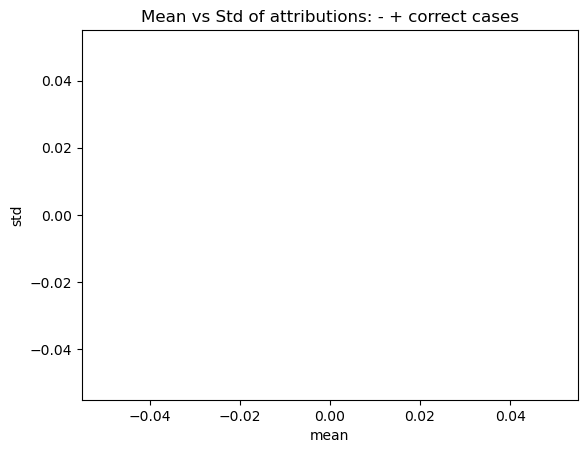

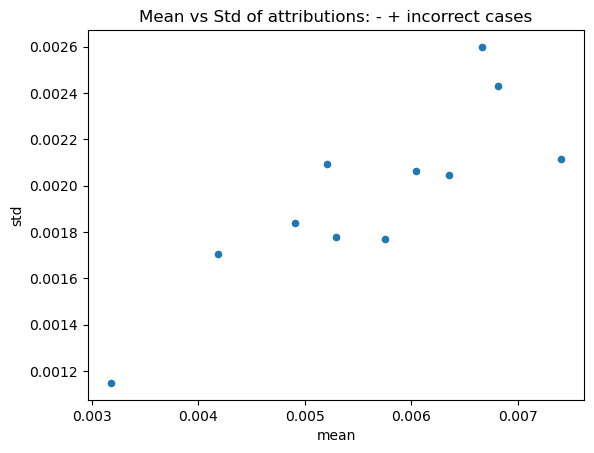

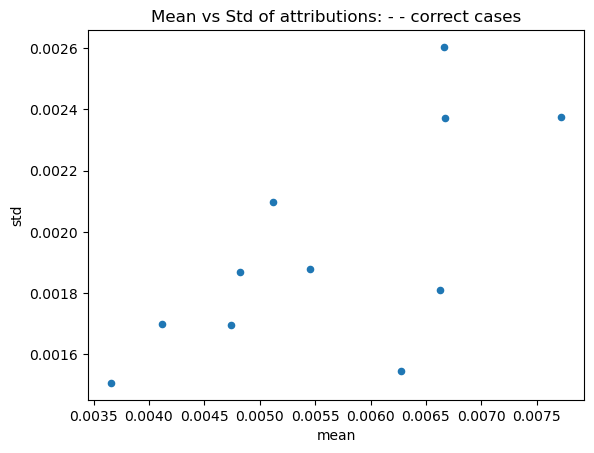

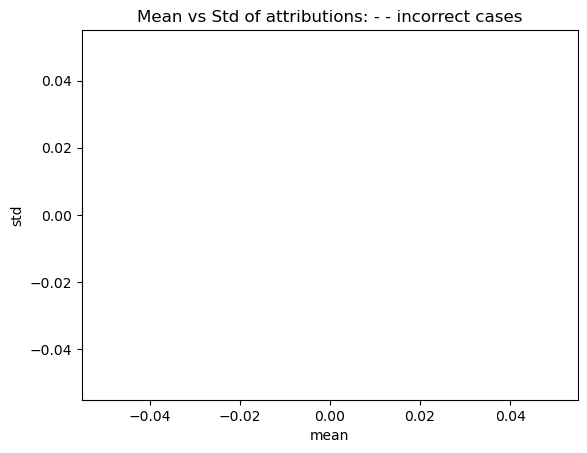

In [27]:
get_col_descriptions(df_attr.loc[mask_agpos & mask_corr]).plot.scatter(x="mean", y="std", title="Mean vs Std of attributions: - + correct cases")
get_col_descriptions(df_attr.loc[mask_agpos & mask_incorr]).plot.scatter(x="mean", y="std", title="Mean vs Std of attributions: - + incorrect cases")
get_col_descriptions(df_attr.loc[mask_agneg & mask_corr]).plot.scatter(x="mean", y="std", title="Mean vs Std of attributions: - - correct cases")
get_col_descriptions(df_attr.loc[mask_agneg & mask_incorr]).plot.scatter(x="mean", y="std", title="Mean vs Std of attributions: - - incorrect cases")

In [28]:
get_col_descriptions(df_attr).sort_values("mean", ascending=False)

,count,mean,std,min,25%,50%,75%,max
Slide position 1,200.0,0.007602,0.002277,0.002570,0.006092,0.007306,0.009314,0.013427
Slide position 11,200.0,0.006666,0.002589,0.001765,0.004749,0.006702,0.008508,0.016616
Slide position 2,200.0,0.006547,0.002240,0.002205,0.004826,0.006492,0.008352,0.012429
Slide position 7,200.0,0.006530,0.002011,0.002265,0.005047,0.006355,0.007569,0.013262
Slide position 6,200.0,0.006227,0.001835,0.002049,0.004946,0.006173,0.007416,0.011559
Slide position 10,200.0,0.005751,0.002010,0.001765,0.004345,0.005440,0.007243,0.010782
Slide position 5,200.0,0.005153,0.002087,0.000709,0.003580,0.004925,0.006539,0.013675
Slide position 3,200.0,0.005028,0.001835,0.001343,0.003713,0.004787,0.005919,0.012043
Slide position 9,200.0,0.004812,0.001755,0.001335,0.003482,0.004857,0.005804,0.011895
Slide position 4,200.0,0.004171,0.001719,0.000703,0.002845,0.003963,0.005209,0.009738


/tmp/ipykernel_23180/886546718.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.clustermap(df_attr.corr(), figsize=(10, 10), cmap="RdBu_r", center=0)


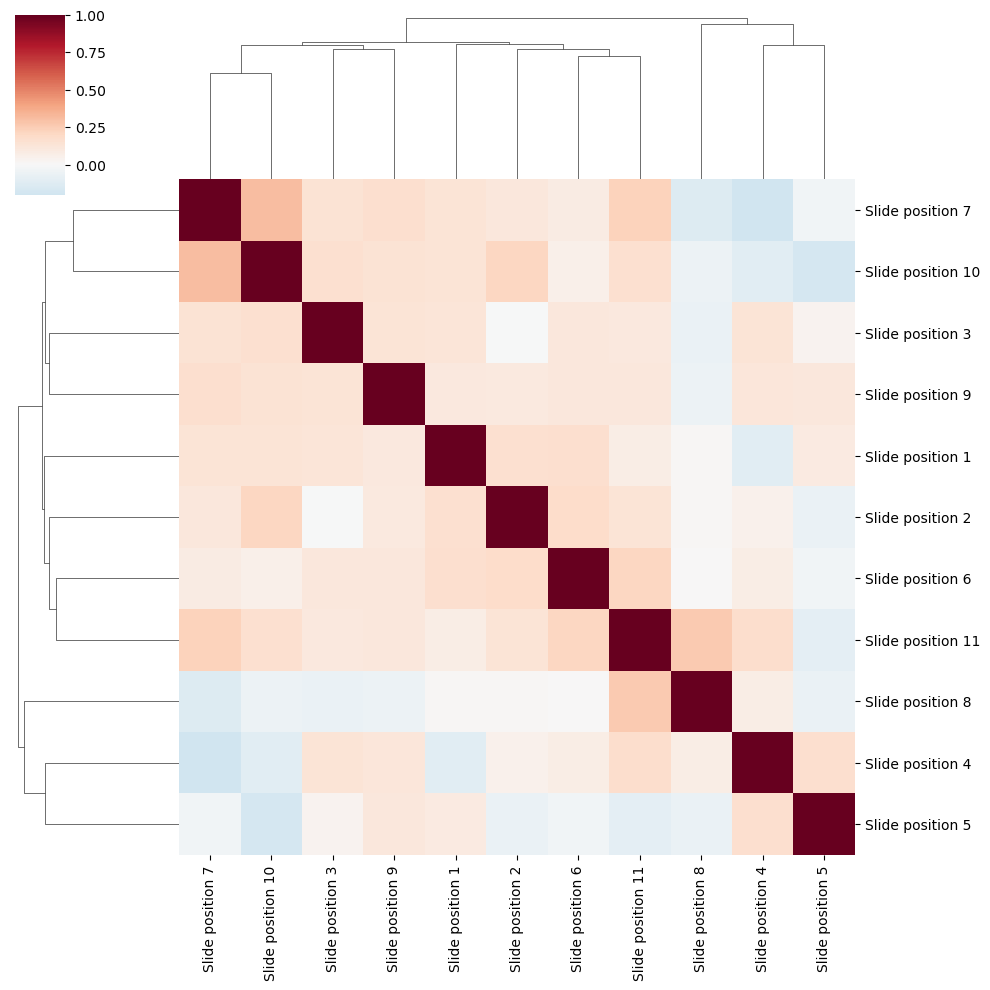

In [29]:
sns.clustermap(df_attr.corr(), figsize=(10, 10), cmap="RdBu_r", center=0)

## Stability of IG

#### Seeds on same split

In [30]:
dfs = []

for seed in range(5):
    
    torch.manual_seed(seed)
    
    model = ml.SN10()
    model = model.to("cpu")

    learning_rate = 0.01
    epochs = 30
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        ml.train_loop(train_loader, model, loss_fn, optimizer)
        ml.test_loop(test_loader, model, loss_fn)

    attributions, df_attr = compute_attributions(test_data, model)
    dfs.append(df_attr)

Epoch 1
-------------------------------
loss: 0.692991  [    0/  800]
Test Error: 
 Acc: 46.0 Avg loss: 0.715584 

Epoch 2
-------------------------------
loss: 0.723196  [    0/  800]
Test Error: 
 Acc: 46.0 Avg loss: 0.703520 

Epoch 3
-------------------------------
loss: 0.702930  [    0/  800]
Test Error: 
 Acc: 46.0 Avg loss: 0.707631 

Epoch 4
-------------------------------
loss: 0.704240  [    0/  800]
Test Error: 
 Acc: 46.0 Avg loss: 0.700717 

Epoch 5
-------------------------------
loss: 0.698179  [    0/  800]
Test Error: 
 Acc: 46.0 Avg loss: 0.702210 

Epoch 6
-------------------------------
loss: 0.673551  [    0/  800]
Test Error: 
 Acc: 46.0 Avg loss: 0.696252 

Epoch 7
-------------------------------
loss: 0.697671  [    0/  800]
Test Error: 
 Acc: 46.0 Avg loss: 0.694362 

Epoch 8
-------------------------------
loss: 0.686633  [    0/  800]
Test Error: 
 Acc: 46.0 Avg loss: 0.691175 

Epoch 9
-------------------------------
loss: 0.678264  [    0/  800]
Test Error

AttributeError: 'SN10' object has no attribute 'attribute_dataset'

In [ ]:
dfs_renamed = []
for i, df in enumerate(dfs):
    dfs_renamed.append(
        df.rename(columns={col: f"{col} | seed={i+1}" for col in df.columns})
    )

df_seeds = pd.concat(dfs_renamed, axis=1)
df_seeds

,seed=1 | Slide position 1 | seed=1,seed=1 | Slide position 2 | seed=1,seed=1 | Slide position 3 | seed=1,seed=1 | Slide position 4 | seed=1,seed=1 | Slide position 5 | seed=1,seed=1 | Slide position 6 | seed=1,seed=1 | Slide position 7 | seed=1,seed=1 | Slide position 8 | seed=1,seed=1 | Slide position 9 | seed=1,seed=1 | Slide position 10 | seed=1,...,seed=5 | Slide position 2 | seed=5,seed=5 | Slide position 3 | seed=5,seed=5 | Slide position 4 | seed=5,seed=5 | Slide position 5 | seed=5,seed=5 | Slide position 6 | seed=5,seed=5 | Slide position 7 | seed=5,seed=5 | Slide position 8 | seed=5,seed=5 | Slide position 9 | seed=5,seed=5 | Slide position 10 | seed=5,seed=5 | Slide position 11 | seed=5
0,0.073529,0.164285,0.033353,0.159594,0.015858,0.149950,0.239113,0.182201,0.068795,0.080441,...,0.162002,0.052240,0.153864,0.006342,0.171555,0.273987,0.178017,0.074063,0.087125,0.126174
1,0.077262,0.157823,0.018971,0.022277,0.019460,0.126461,0.255927,0.202394,0.007579,0.080222,...,0.158530,0.009716,0.024512,0.028595,0.141744,0.283254,0.206340,0.002737,0.086866,0.033403
2,0.021885,0.037365,0.047099,0.002439,0.023037,0.029159,0.005173,0.014745,0.008126,0.019060,...,0.026926,0.039430,0.003613,0.022010,0.023374,0.003586,0.014291,0.008770,0.017234,0.023490
3,0.017257,0.026082,0.027069,0.002004,0.000685,0.018287,0.026314,0.003279,0.017258,0.006355,...,0.015849,0.025381,0.000443,0.001314,0.017288,0.024089,0.006588,0.016925,0.009381,0.013335
4,0.014784,0.023385,0.000232,0.036547,0.006526,0.016308,0.000111,0.008512,0.021056,0.052693,...,0.015700,0.002136,0.032295,0.005099,0.016914,0.001808,0.005821,0.018164,0.047212,0.013276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.049001,0.086209,0.000048,0.301773,0.018536,0.284819,0.031249,0.246315,0.106039,0.093190,...,0.089672,0.007642,0.317572,0.023326,0.289687,0.023759,0.256403,0.108853,0.083515,0.032990
3996,0.025953,0.047464,0.000730,0.109963,0.021050,0.155205,0.016446,0.134505,0.058152,0.050276,...,0.042290,0.003432,0.090802,0.015961,0.135736,0.011075,0.120148,0.051437,0.039109,0.015135
3997,0.044982,0.086750,0.027955,0.302333,0.066504,0.173741,0.031239,0.247605,0.106462,0.101741,...,0.089542,0.034500,0.315780,0.067422,0.178446,0.023354,0.261683,0.109745,0.111030,0.030570
3998,0.019836,0.066741,0.020443,0.069706,0.035842,0.172622,0.248813,0.224482,0.007285,0.088719,...,0.070711,0.013305,0.073836,0.046669,0.199142,0.268928,0.229312,0.002670,0.096760,0.037242


In [ ]:
df_ = pd.concat(dfs, axis=1)
df_ = df_.reindex(sorted(df_.columns), axis=1)
df_

,Slide position 1 | seed=1,Slide position 1 | seed=2,Slide position 1 | seed=3,Slide position 1 | seed=4,Slide position 1 | seed=5,Slide position 10 | seed=1,Slide position 10 | seed=2,Slide position 10 | seed=3,Slide position 10 | seed=4,Slide position 10 | seed=5,...,Slide position 8 | seed=1,Slide position 8 | seed=2,Slide position 8 | seed=3,Slide position 8 | seed=4,Slide position 8 | seed=5,Slide position 9 | seed=1,Slide position 9 | seed=2,Slide position 9 | seed=3,Slide position 9 | seed=4,Slide position 9 | seed=5
0,0.073529,0.053016,0.069560,0.057104,0.071061,0.080441,0.085039,0.100927,0.093720,0.087125,...,0.182201,0.181590,0.174257,0.175150,0.178017,0.068795,0.070304,0.067085,0.058184,0.074063
1,0.077262,0.050790,0.076846,0.054639,0.076225,0.080222,0.081230,0.099788,0.089047,0.086866,...,0.202394,0.193388,0.197431,0.190506,0.206340,0.007579,0.018189,0.001328,0.007563,0.002737
2,0.021885,0.014241,0.020378,0.018867,0.019379,0.019060,0.018978,0.019915,0.019893,0.017234,...,0.014745,0.023020,0.013888,0.013243,0.014291,0.008126,0.011079,0.007658,0.005662,0.008770
3,0.017257,0.009712,0.019211,0.018409,0.016642,0.006355,0.005347,0.008068,0.017024,0.009381,...,0.003279,0.001168,0.003686,0.002362,0.006588,0.017258,0.002246,0.015630,0.016269,0.016925
4,0.014784,0.010303,0.015066,0.014114,0.012266,0.052693,0.035090,0.044516,0.044777,0.047212,...,0.008512,0.007491,0.008545,0.010801,0.005821,0.021056,0.009325,0.012556,0.016858,0.018164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.049001,0.013888,0.038070,0.029378,0.037500,0.093190,0.079817,0.067244,0.076350,0.083515,...,0.246315,0.199454,0.237515,0.233821,0.256403,0.106039,0.054470,0.106952,0.095469,0.108853
3996,0.025953,0.007818,0.019406,0.014677,0.017731,0.050276,0.044057,0.032650,0.038585,0.039109,...,0.134505,0.109939,0.119277,0.117557,0.120148,0.058152,0.029985,0.054635,0.049101,0.051437
3997,0.044982,0.014013,0.038638,0.029760,0.034922,0.101741,0.070261,0.123921,0.111179,0.111030,...,0.247605,0.201805,0.241255,0.237465,0.261683,0.106462,0.055200,0.108515,0.097784,0.109745
3998,0.019836,0.015787,0.024964,0.019318,0.025662,0.088719,0.088613,0.110594,0.101558,0.096760,...,0.224482,0.211227,0.219512,0.215112,0.229312,0.007285,0.019790,0.001701,0.007327,0.002670


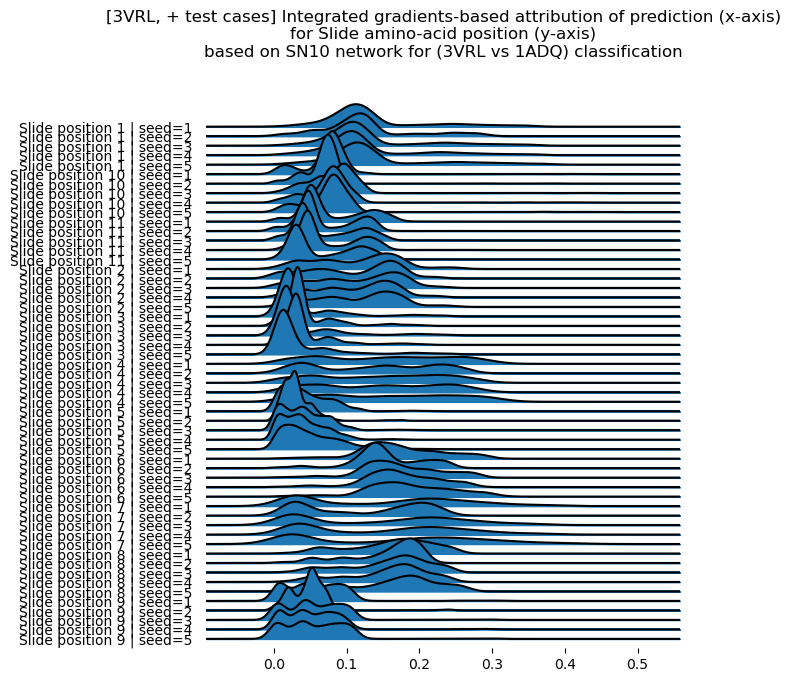

In [ ]:
# joypy.joyplot(df_ext, figsize=(20, 15))
g = joypy.joyplot(
    df_.loc[mask_agpos],
    figsize=(7, 7),
    title="[3VRL, + test cases] Integrated gradients-based attribution of prediction (x-axis)\nfor Slide amino-acid position (y-axis)\nbased on SN10 network for (3VRL vs 1ADQ) classification")

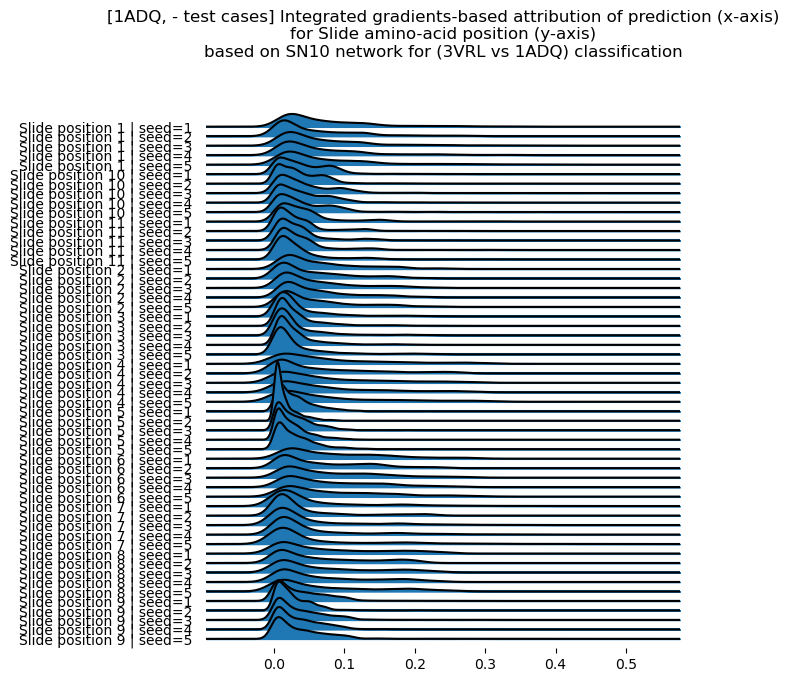

In [ ]:
# joypy.joyplot(df_ext, figsize=(20, 15))
g = joypy.joyplot(
    df_.loc[mask_agneg],
    figsize=(7, 7),
    title="[1ADQ, - test cases] Integrated gradients-based attribution of prediction (x-axis)\nfor Slide amino-acid position (y-axis)\nbased on SN10 network for (3VRL vs 1ADQ) classification")

#### Different data splits

In [ ]:
dfs = []
for _ in range(5):
    
    df_shuffled = df.sample(frac=1)
    df_train = df_shuffled.iloc[:int(N*0.8)]
    df_test = df_shuffled.iloc[int(N*0.8):]

    train_data, test_data, train_loader, test_loader = preprocessing.preprocess_data_for_pytorch_binary(
        df_train_val=df_train,
        df_test_closed=df_test,
        ag_pos=[ag_pos],
        batch_size=32,
        scale_onehot=False,
    )
    
    model = ml.SN10()
    model = model.to("cpu")

    learning_rate = 0.01
    epochs = 30
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        ml.train_loop(train_loader, model, loss_fn, optimizer)
        ml.test_loop(test_loader, model, loss_fn)

    attributions, df_attr = compute_attributions(test_data, model)
    dfs.append(df_attr)

/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Epoch 1
-------------------------------
loss: 0.699721  [    0/16000]
loss: 0.672908  [ 3200/16000]
loss: 0.694689  [ 6400/16000]
loss: 0.681300  [ 9600/16000]
loss: 0.654835  [12800/16000]
Test Error: 
 Acc: 76.7 Avg loss: 0.640452 

Epoch 2
-------------------------------
loss: 0.643783  [    0/16000]
loss: 0.608165  [ 3200/16000]
loss: 0.601605  [ 6400/16000]
loss: 0.563202  [ 9600/16000]
loss: 0.572586  [12800/16000]
Test Error: 
 Acc: 79.7 Avg loss: 0.537647 

Epoch 3
-------------------------------
loss: 0.518065  [    0/16000]
loss: 0.528976  [ 3200/16000]
loss: 0.500151  [ 6400/16000]
loss: 0.457069  [ 9600/16000]
loss: 0.458832  [12800/16000]
Test Error: 
 Acc: 81.3 Avg loss: 0.465162 

Epoch 4
-------------------------------
loss: 0.653579  [    0/16000]
loss: 0.469033  [ 3200/16000]
loss: 0.451482  [ 6400/16000]
loss: 0.411293  [ 9600/16000]
loss: 0.435118  [12800/16000]
Test Error: 
 Acc: 82.4 Avg loss: 0.425896 

Epoch 5
-------------------------------
loss: 0.469863  [   

/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Epoch 1
-------------------------------
loss: 0.705748  [    0/16000]
loss: 0.675359  [ 3200/16000]
loss: 0.708695  [ 6400/16000]
loss: 0.668031  [ 9600/16000]
loss: 0.660942  [12800/16000]
Test Error: 
 Acc: 78.9 Avg loss: 0.631165 

Epoch 2
-------------------------------
loss: 0.629737  [    0/16000]
loss: 0.602684  [ 3200/16000]
loss: 0.577876  [ 6400/16000]
loss: 0.506528  [ 9600/16000]
loss: 0.553408  [12800/16000]
Test Error: 
 Acc: 80.6 Avg loss: 0.511384 

Epoch 3
-------------------------------
loss: 0.448322  [    0/16000]
loss: 0.420977  [ 3200/16000]
loss: 0.470907  [ 6400/16000]
loss: 0.427624  [ 9600/16000]
loss: 0.413732  [12800/16000]
Test Error: 
 Acc: 82.0 Avg loss: 0.440658 

Epoch 4
-------------------------------
loss: 0.430527  [    0/16000]
loss: 0.462713  [ 3200/16000]
loss: 0.462235  [ 6400/16000]
loss: 0.440829  [ 9600/16000]
loss: 0.480690  [12800/16000]
Test Error: 
 Acc: 83.3 Avg loss: 0.406794 

Epoch 5
-------------------------------
loss: 0.249862  [   

/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Epoch 1
-------------------------------
loss: 0.714021  [    0/16000]
loss: 0.685996  [ 3200/16000]
loss: 0.688176  [ 6400/16000]
loss: 0.673090  [ 9600/16000]
loss: 0.652785  [12800/16000]
Test Error: 
 Acc: 74.9 Avg loss: 0.640303 

Epoch 2
-------------------------------
loss: 0.607849  [    0/16000]
loss: 0.599005  [ 3200/16000]
loss: 0.595647  [ 6400/16000]
loss: 0.612161  [ 9600/16000]
loss: 0.566778  [12800/16000]
Test Error: 
 Acc: 78.4 Avg loss: 0.544303 

Epoch 3
-------------------------------
loss: 0.506236  [    0/16000]
loss: 0.534896  [ 3200/16000]
loss: 0.515607  [ 6400/16000]
loss: 0.513705  [ 9600/16000]
loss: 0.529995  [12800/16000]
Test Error: 
 Acc: 80.8 Avg loss: 0.471321 

Epoch 4
-------------------------------
loss: 0.470610  [    0/16000]
loss: 0.451308  [ 3200/16000]
loss: 0.417108  [ 6400/16000]
loss: 0.580161  [ 9600/16000]
loss: 0.402770  [12800/16000]
Test Error: 
 Acc: 82.4 Avg loss: 0.429276 

Epoch 5
-------------------------------
loss: 0.577753  [   

/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Epoch 1
-------------------------------
loss: 0.690926  [    0/16000]
loss: 0.679435  [ 3200/16000]
loss: 0.685213  [ 6400/16000]
loss: 0.679909  [ 9600/16000]
loss: 0.657863  [12800/16000]
Test Error: 
 Acc: 74.5 Avg loss: 0.642961 

Epoch 2
-------------------------------
loss: 0.650933  [    0/16000]
loss: 0.605869  [ 3200/16000]
loss: 0.659435  [ 6400/16000]
loss: 0.584674  [ 9600/16000]
loss: 0.580235  [12800/16000]
Test Error: 
 Acc: 80.0 Avg loss: 0.545073 

Epoch 3
-------------------------------
loss: 0.551479  [    0/16000]
loss: 0.578633  [ 3200/16000]
loss: 0.345461  [ 6400/16000]
loss: 0.529860  [ 9600/16000]
loss: 0.567798  [12800/16000]
Test Error: 
 Acc: 81.7 Avg loss: 0.468151 

Epoch 4
-------------------------------
loss: 0.406856  [    0/16000]
loss: 0.456941  [ 3200/16000]
loss: 0.445128  [ 6400/16000]
loss: 0.511119  [ 9600/16000]
loss: 0.344489  [12800/16000]
Test Error: 
 Acc: 82.8 Avg loss: 0.426361 

Epoch 5
-------------------------------
loss: 0.343644  [   

/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Epoch 1
-------------------------------
loss: 0.673246  [    0/16000]
loss: 0.683452  [ 3200/16000]
loss: 0.676864  [ 6400/16000]
loss: 0.670985  [ 9600/16000]
loss: 0.660133  [12800/16000]
Test Error: 
 Acc: 64.6 Avg loss: 0.650594 

Epoch 2
-------------------------------
loss: 0.615594  [    0/16000]
loss: 0.632264  [ 3200/16000]
loss: 0.605687  [ 6400/16000]
loss: 0.609151  [ 9600/16000]
loss: 0.643727  [12800/16000]
Test Error: 
 Acc: 78.1 Avg loss: 0.571639 

Epoch 3
-------------------------------
loss: 0.610979  [    0/16000]
loss: 0.569499  [ 3200/16000]
loss: 0.495749  [ 6400/16000]
loss: 0.497035  [ 9600/16000]
loss: 0.540515  [12800/16000]
Test Error: 
 Acc: 81.2 Avg loss: 0.499835 

Epoch 4
-------------------------------
loss: 0.410833  [    0/16000]
loss: 0.563623  [ 3200/16000]
loss: 0.476409  [ 6400/16000]
loss: 0.520790  [ 9600/16000]
loss: 0.462649  [12800/16000]
Test Error: 
 Acc: 82.4 Avg loss: 0.449318 

Epoch 5
-------------------------------
loss: 0.410123  [   

In [ ]:
dfs_renamed = []
for i, df in enumerate(dfs):
    dfs_renamed.append(
        df.rename(columns={col: f"{col} | split_id={i+1}" for col in df.columns})
    )

df_seeds = pd.concat(dfs_renamed, axis=1)
df_seeds = df_seeds.reindex(sorted(df_seeds.columns), axis=1)
df_seeds

,Slide position 1 | split_id=1,Slide position 1 | split_id=2,Slide position 1 | split_id=3,Slide position 1 | split_id=4,Slide position 1 | split_id=5,Slide position 10 | split_id=1,Slide position 10 | split_id=2,Slide position 10 | split_id=3,Slide position 10 | split_id=4,Slide position 10 | split_id=5,...,Slide position 8 | split_id=1,Slide position 8 | split_id=2,Slide position 8 | split_id=3,Slide position 8 | split_id=4,Slide position 8 | split_id=5,Slide position 9 | split_id=1,Slide position 9 | split_id=2,Slide position 9 | split_id=3,Slide position 9 | split_id=4,Slide position 9 | split_id=5
0,0.031629,0.086066,0.060372,0.012453,0.064720,0.017741,0.104407,0.085227,0.005342,0.060701,...,0.082112,0.117687,0.187257,0.012215,0.202598,0.043793,0.058010,0.055133,0.006219,0.087306
1,0.015827,0.008144,0.045272,0.063345,0.068898,0.000616,0.002789,0.015634,0.051838,0.057487,...,0.003261,0.002340,0.089084,0.181446,0.210949,0.007333,0.001183,0.180618,0.079303,0.086723
2,0.016114,0.029972,0.068202,0.037936,0.039276,0.012669,0.022978,0.094711,0.031418,0.028487,...,0.001285,0.076687,0.123699,0.107883,0.089380,0.015132,0.030678,0.065455,0.046485,0.157267
3,0.016015,0.017410,0.030083,0.016176,0.017847,0.019489,0.004923,0.030913,0.002147,0.011540,...,0.015848,0.004289,0.097029,0.006302,0.051398,0.001590,0.002999,0.049544,0.008061,0.010741
4,0.023852,0.014896,0.016503,0.016994,0.007987,0.009175,0.018274,0.019939,0.026195,0.002499,...,0.051248,0.017407,0.024952,0.021314,0.007980,0.003411,0.006422,0.008013,0.009989,0.001297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.008636,0.047576,0.032965,0.022753,0.010445,0.064525,0.109114,0.096150,0.051950,0.024989,...,0.112578,0.114592,0.050601,0.181481,0.092972,0.019599,0.061294,0.108333,0.078966,0.041306
3996,0.020315,0.019498,0.031180,0.027531,0.002176,0.042284,0.026115,0.093617,0.058260,0.003116,...,0.198348,0.106315,0.050614,0.211295,0.003349,0.104658,0.032778,0.106055,0.050670,0.020866
3997,0.011484,0.039439,0.015608,0.025896,0.026325,0.105461,0.073334,0.033830,0.058569,0.062727,...,0.039730,0.231128,0.106313,0.206086,0.204768,0.099953,0.100142,0.054198,0.090136,0.037453
3998,0.011874,0.043656,0.028674,0.026223,0.001097,0.103464,0.104853,0.087410,0.104758,0.031881,...,0.196692,0.236611,0.047862,0.186934,0.002983,0.037683,0.015592,0.099092,0.051335,0.015863


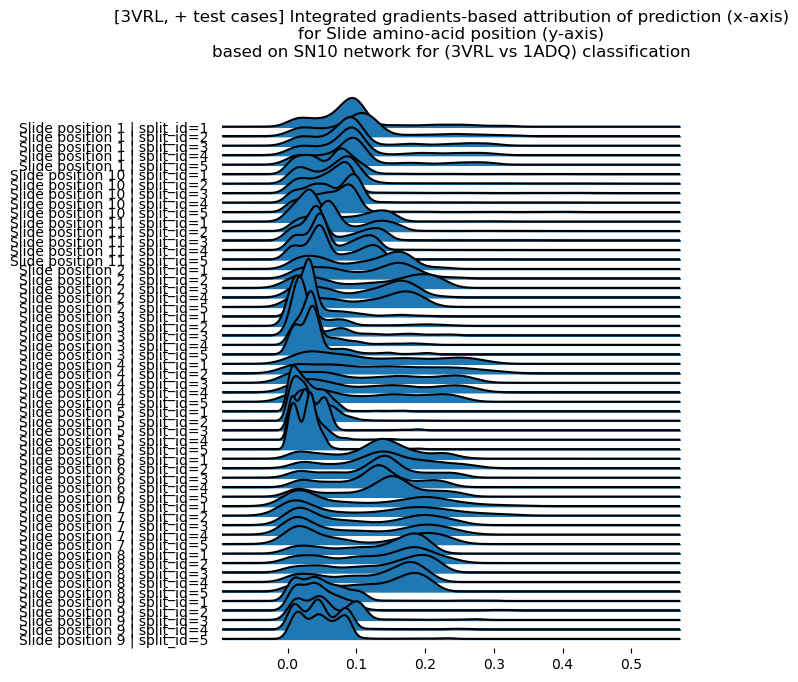

In [ ]:
# joypy.joyplot(df_ext, figsize=(20, 15))
g = joypy.joyplot(
    df_seeds.loc[mask_agpos],
    figsize=(7, 7),
    title="[3VRL, + test cases] Integrated gradients-based attribution of prediction (x-axis)\nfor Slide amino-acid position (y-axis)\nbased on SN10 network for (3VRL vs 1ADQ) classification")

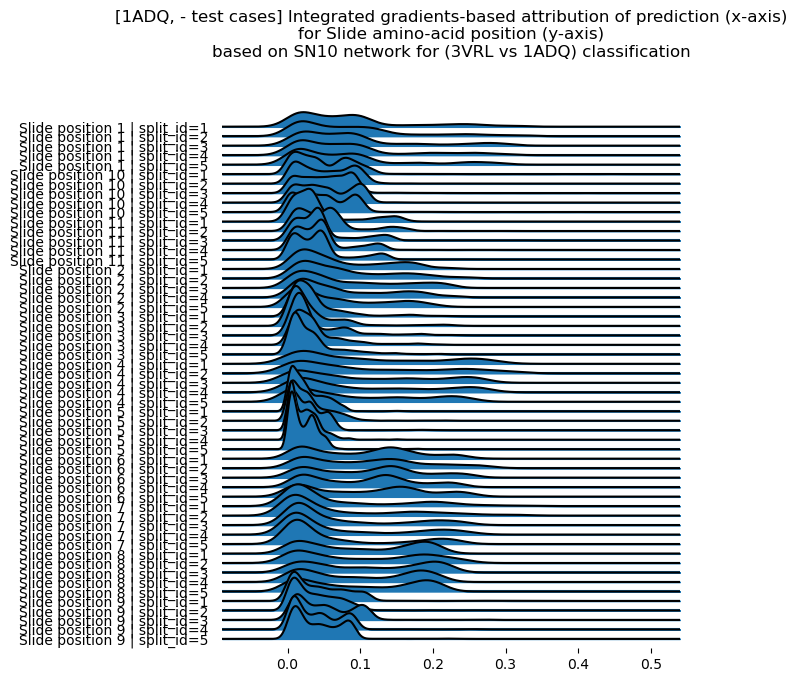

In [ ]:
# joypy.joyplot(df_ext, figsize=(20, 15))
g = joypy.joyplot(
    df_seeds.loc[mask_agneg],
    figsize=(7, 7),
    title="[1ADQ, - test cases] Integrated gradients-based attribution of prediction (x-axis)\nfor Slide amino-acid position (y-axis)\nbased on SN10 network for (3VRL vs 1ADQ) classification")